## Classification - Logistic Regression

In this notebook we're going to
1. Looking at fitting a logistic regression model to a sample dataset
2. How you determine feature importance with logistic regression
3. Get Accuracy for your model
4. Get precision / recall for your model

In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

data = load_breast_cancer()
df = pd.DataFrame(data=data['data'], columns=data['feature_names'])
target = data['target']
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [2]:
df.shape

(569, 30)

In [3]:
data['target_names']

array(['malignant', 'benign'], dtype='<U9')

In [4]:
negative_obs_count = len(target[target == 0])
positive_obs_count = len(target[target == 1])
total_observations = df.shape[0]
print("Malignant observations ", negative_obs_count)
print("Benign observations ", positive_obs_count)
assert negative_obs_count + positive_obs_count == total_observations

Malignant observations  212
Benign observations  357


In [5]:
print("Negative observations: {:.2f}".format(negative_obs_count / total_observations))
print("Postive observations: {:.2f}".format(positive_obs_count / total_observations))

Negative observations: 0.37
Postive observations: 0.63


## PCA for plot

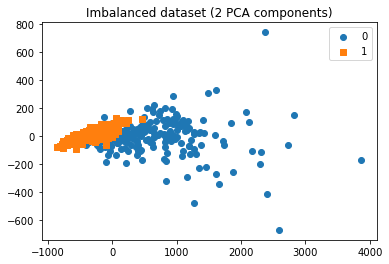

In [6]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()
    
pca = PCA(n_components=2)
X = pca.fit_transform(df)

plot_2d_space(X, target, 'Imbalanced dataset (2 PCA components)')

## Fit Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Initialize our classifier
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.33, random_state=4)

clf = LogisticRegression(solver='liblinear')
model = clf.fit(X_train, y_train)

print("Accuracy (Train): {:.4f}".format(accuracy_score(y_train, clf.predict(X_train))))
print("Accuracy (Test): {:.4f}".format(accuracy_score(y_test, clf.predict(X_test))))

Accuracy (Train): 0.9633
Accuracy (Test): 0.9043


### Confusion Matrix

In [8]:
from sklearn.metrics import confusion_matrix

cf_df = pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test)))
cf_df

,0,1
0,52,8
1,10,118


### Classification Report

In [9]:
from sklearn.metrics import classification_report
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85        60
           1       0.94      0.92      0.93       128

    accuracy                           0.90       188
   macro avg       0.89      0.89      0.89       188
weighted avg       0.91      0.90      0.90       188



## Feature importance

In [10]:
from sklearn.feature_selection import RFE
import numpy as np
predictors = X_train
clf = LogisticRegression(solver='liblinear')
selector = RFE(clf, n_features_to_select = 1)
selector.fit(predictors, y_train)

RFE(estimator=LogisticRegression(solver='liblinear'), n_features_to_select=1)

In [11]:
order = selector.ranking_
order

array([ 8, 15,  9, 27, 10, 18,  4,  5,  7, 25,  2,  6, 26, 16, 29, 28, 22,
       24, 23, 30, 19, 14, 17, 21, 12, 20,  1,  3, 13, 11])

In [12]:
ranked_features_df = pd.DataFrame.from_dict({'feature_name': X_train.columns.values, 
                                             "col_index": np.linspace(1, len(X_train.columns.values), num=len(X_train.columns.values)),
                                             "rank" : np.zeros(len(X_train.columns))})
ranked_features_df.set_index('feature_name', inplace=True)

In [13]:
for i, rank in enumerate(order):
    feature_name = X_train.columns[rank-1]    
    ranked_features_df.loc[feature_name]['rank'] = i+1

In [14]:
ranked_features_df.sort_values(by='rank').head()

,col_index,rank
feature_name,,
mean concave points,8.0,1.0
smoothness error,15.0,2.0
mean symmetry,9.0,3.0
worst concavity,27.0,4.0
mean fractal dimension,10.0,5.0


In [15]:
X_train.shape

(381, 30)

In [16]:
df_top_features = ranked_features_df.sort_values(by='rank').head(18)
df_top_features.index.values
X_train_min = X_train[df_top_features.index.values]
X_test_min = X_test[df_top_features.index.values]

clf = LogisticRegression(solver='liblinear')
model = clf.fit(X_train_min, y_train)

print("Accuracy (Train): {:.4f}".format(accuracy_score(y_train, clf.predict(X_train_min))))
print("Accuracy (Test): {:.4f}".format(accuracy_score(y_test, clf.predict(X_test_min))))

Accuracy (Train): 0.9554
Accuracy (Test): 0.9043
